<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_2021_aug_tabular_playground_series_aug_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
train.shape, test.shape, submit.shape

((250000, 102), (150000, 101), (150000, 2))

In [ ]:
train['loss'].skew()  # target 라벨에 log1p씌울까 

1.4653191365369271

Text(0.5, 1.0, 'Train set Skew')

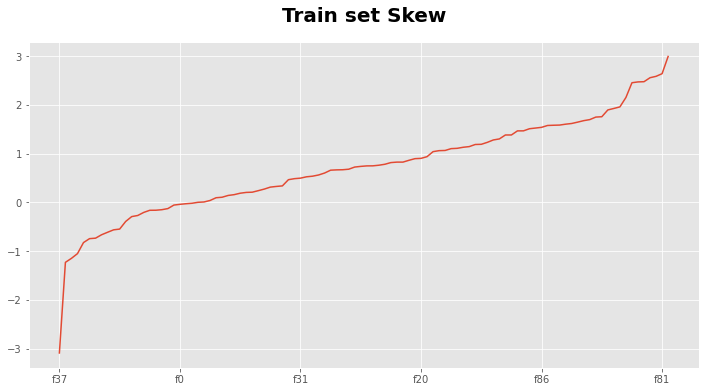

In [ ]:
plt.figure(figsize=(12,6))
train.skew().sort_values().plot()
plt.title('Train set Skew', fontsize=20, fontweight='bold', pad=20)
# noramlize를 적용 할까 고민

# cluster DBSCAN기법

- DBSCAN(density-based spatial clustering of application with noise)은 클러스터의 갯수를 미리 지정하지 않는 군집 알고리즘


- DBSCAN은 병합 군집이나 k-평균보다는 다소 느리지만 비교적 큰 데이터셋에도 적용



- 데이터의 밀집지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분함



- DBSCAN은 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾음

- 이런 지역을 밀집 지역dense region이라 함

- 밀집 지역에 있는 포인트를 핵심 포인트core point라고함



- 핵심 포인트: min_samples, epsepsilon

  - 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류

  - eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])], axis=0)
data_columns = data.columns

for i in data.columns:
  if i == 'loss':
    continue
  data[i] = MinMaxScaler().fit_transform(data[[i]])

In [ ]:
from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(n_jobs=-1).fit_predict(data.drop(columns=['loss']))
data

KeyboardInterrupt: ignored

# Clustering 적용하자

In [3]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 45 kB/s 
     |████████████████████████████████| 302 kB 12.5 MB/s 
     |████████████████████████████████| 164 kB 73.0 MB/s 
     |████████████████████████████████| 80 kB 12.0 MB/s 
     |████████████████████████████████| 75 kB 5.7 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 111 kB 67.4 MB/s 
     |████████████████████████████████| 141 kB 66.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=f880e443666aea0a7312f28f71b572622924526a3a3eb1cd5e1936c7d877d110
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
import catboost
import optuna
import optuna.integration.lightgbm as lgbo
import lightgbm
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneGroupOut, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
# 데이터 나누기
x_train = train.drop(columns=['id', 'loss'])
y_train = train['loss']
x_test = test.drop(columns=['id'])
x_train_columns = x_train.columns
x_test_columns = x_test.columns
x_train.shape, y_train.shape, x_test.shape

((250000, 100), (250000,), (150000, 100))

In [6]:
mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'elbow method')

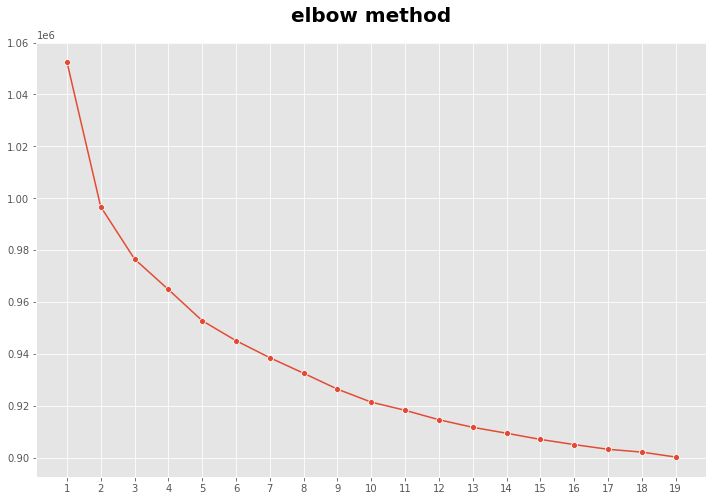

In [ ]:
# Clustering
from sklearn.cluster import KMeans

vstack = np.vstack((x_train,
                    x_test))

sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=0, n_jobs=-1).fit(vstack)
  sse[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_splits=, max_iter=1000, n_jobs=-1).fit(vstack)

x_train['cluster'] = km.predict(x_train)
x_test['cluster'] = km.predict(x_test)

In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.022, loss_function='RMSE', eval_metric='RMSE', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.1039045	test: 1.1063753	best: 1.1063753 (0)	total: 10.3ms	remaining: 30.9s
100:	learn: 1.0945647	test: 1.0977858	best: 1.0977858 (100)	total: 1.8s	remaining: 51.6s
200:	learn: 1.0901819	test: 1.0942911	best: 1.0942911 (200)	total: 2.91s	remaining: 40.6s
300:	learn: 1.0869794	test: 1.0920953	best: 1.0920953 (300)	total: 4.21s	remaining: 37.7s
400:	learn: 1.0843921	test: 1.0905177	best: 1.0905177 (400)	total: 5.58s	remaining: 36.2s
500:	learn: 1.0821666	test: 1.0893155	best: 1.0893155 (500)	total: 7.41s	remaining: 37s
600:	learn: 1.0800835	test: 1.0882926	best: 1.0882926 (600)	total: 9.82s	remaining: 39.2s
700:	learn: 1.0781490	test: 1.0874149	best: 1.0874149 (700)	total: 12.1s	remaining: 39.7s
800:	learn: 1.0763697	test: 1.0866818	best: 1.0866818 (800)	total: 14.4s	remaining: 39.6s
900:	learn: 1.0746677	test: 1.0860741	best: 1.0860741 (900)	total: 16.9s	remaining: 39.3s
1000:	learn: 1.0730308	test: 1.0855342	best: 1.0855342 (1000)	total: 18.9s	remaining: 37.8s
1100:	learn: 1

# LGBM LB: 7.90478

In [7]:
params = {'objective':'poisson', 'metric': 'rmse' } #'objective': 'mean_squared_error',
from sklearn.metrics import mean_absolute_error
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
lgb_train = lightgbm.Dataset(X_train, Y_train)
lgb_valid = lightgbm.Dataset(X_test, Y_test)
model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params

[I 2021-08-18 05:02:16,633] A new study created in memory with name: no-name-be07a32d-e1d9-4064-b006-e544d9d99343
min_data_in_leaf, val_score: 7.871026: 100%|##########| 5/5 [00:55<00:00, 11.10s/it]


{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.5,
 'feature_pre_filter': False,
 'lambda_l1': 0.0042378208076094106,
 'lambda_l2': 5.817712128333037e-06,
 'metric': 'rmse',
 'min_child_samples': 50,
 'num_leaves': 82,
 'objective': 'poisson'}

In [8]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
best_lgb_params = model.params
best_lgb_params["learning_rate"] = 0.006
best_lgb_params["num_iterations"] = 80000

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgb = lightgbm.LGBMRegressor(**best_lgb_params)
  model_lgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70)

  preds += model_lgb.predict(x_test) / kf.n_splits
  val_preds = model_lgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.92044	valid_1's rmse: 7.90716
[200]	training's rmse: 7.898	valid_1's rmse: 7.8974
[300]	training's rmse: 7.87728	valid_1's rmse: 7.88949
[400]	training's rmse: 7.85811	valid_1's rmse: 7.88296
[500]	training's rmse: 7.83967	valid_1's rmse: 7.87724
[600]	training's rmse: 7.82188	valid_1's rmse: 7.87237
[700]	training's rmse: 7.80461	valid_1's rmse: 7.86794
[800]	training's rmse: 7.78778	valid_1's rmse: 7.86388
[900]	training's rmse: 7.77117	valid_1's rmse: 7.86012
[1000]	training's rmse: 7.75493	valid_1's rmse: 7.85671
[1100]	training's rmse: 7.73895	valid_1's rmse: 7.85364
[1200]	training's rmse: 7.72332	valid_1's rmse: 7.85101
[1300]	training's rmse: 7.70793	valid_1's rmse: 7.84836
[1400]	training's rmse: 7.69261	valid_1's rmse: 7.84583
[1500]	training's rmse: 7.67759	valid_1's rmse: 7.84365
[1600]	training's rmse: 7.66276	valid_1's rmse: 7.84153
[1700]	training's rmse: 7.64803	valid_1's rmse: 7.8395

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.90867	valid_1's rmse: 7.95375
[200]	training's rmse: 7.88581	valid_1's rmse: 7.94489
[300]	training's rmse: 7.86488	valid_1's rmse: 7.93767
[400]	training's rmse: 7.84551	valid_1's rmse: 7.9318
[500]	training's rmse: 7.82691	valid_1's rmse: 7.92672
[600]	training's rmse: 7.80905	valid_1's rmse: 7.92237
[700]	training's rmse: 7.79155	valid_1's rmse: 7.91854
[800]	training's rmse: 7.77449	valid_1's rmse: 7.91496
[900]	training's rmse: 7.75769	valid_1's rmse: 7.91163
[1000]	training's rmse: 7.74123	valid_1's rmse: 7.90864
[1100]	training's rmse: 7.72514	valid_1's rmse: 7.90605
[1200]	training's rmse: 7.70938	valid_1's rmse: 7.90366
[1300]	training's rmse: 7.69383	valid_1's rmse: 7.90128
[1400]	training's rmse: 7.6785	valid_1's rmse: 7.89927
[1500]	training's rmse: 7.6634	valid_1's rmse: 7.89742
[1600]	training's rmse: 7.64841	valid_1's rmse: 7.89582
[1700]	training's rmse: 7.63367	valid_1's rmse: 7.8943

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.91149	valid_1's rmse: 7.94321
[200]	training's rmse: 7.88918	valid_1's rmse: 7.93323
[300]	training's rmse: 7.86855	valid_1's rmse: 7.92511
[400]	training's rmse: 7.84926	valid_1's rmse: 7.91856
[500]	training's rmse: 7.83078	valid_1's rmse: 7.91275
[600]	training's rmse: 7.81304	valid_1's rmse: 7.90771
[700]	training's rmse: 7.79597	valid_1's rmse: 7.90316
[800]	training's rmse: 7.77926	valid_1's rmse: 7.8992
[900]	training's rmse: 7.76287	valid_1's rmse: 7.89548
[1000]	training's rmse: 7.7468	valid_1's rmse: 7.89221
[1100]	training's rmse: 7.73098	valid_1's rmse: 7.88914
[1200]	training's rmse: 7.71536	valid_1's rmse: 7.88604
[1300]	training's rmse: 7.69998	valid_1's rmse: 7.88345
[1400]	training's rmse: 7.68479	valid_1's rmse: 7.88082
[1500]	training's rmse: 7.66972	valid_1's rmse: 7.87824
[1600]	training's rmse: 7.65477	valid_1's rmse: 7.87576
[1700]	training's rmse: 7.64012	valid_1's rmse: 7.873

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.91751	valid_1's rmse: 7.91869
[200]	training's rmse: 7.89489	valid_1's rmse: 7.9091
[300]	training's rmse: 7.87405	valid_1's rmse: 7.90131
[400]	training's rmse: 7.85462	valid_1's rmse: 7.89484
[500]	training's rmse: 7.83601	valid_1's rmse: 7.8894
[600]	training's rmse: 7.81797	valid_1's rmse: 7.88463
[700]	training's rmse: 7.80063	valid_1's rmse: 7.8805
[800]	training's rmse: 7.78351	valid_1's rmse: 7.87678
[900]	training's rmse: 7.76698	valid_1's rmse: 7.87332
[1000]	training's rmse: 7.75071	valid_1's rmse: 7.87014
[1100]	training's rmse: 7.73462	valid_1's rmse: 7.86718
[1200]	training's rmse: 7.71883	valid_1's rmse: 7.86477
[1300]	training's rmse: 7.70332	valid_1's rmse: 7.86245
[1400]	training's rmse: 7.688	valid_1's rmse: 7.86047
[1500]	training's rmse: 7.67292	valid_1's rmse: 7.85839
[1600]	training's rmse: 7.65795	valid_1's rmse: 7.85667
[1700]	training's rmse: 7.64324	valid_1's rmse: 7.85495


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.91743	valid_1's rmse: 7.91721
[200]	training's rmse: 7.89475	valid_1's rmse: 7.90752
[300]	training's rmse: 7.87374	valid_1's rmse: 7.89955
[400]	training's rmse: 7.85429	valid_1's rmse: 7.89325
[500]	training's rmse: 7.83568	valid_1's rmse: 7.88788
[600]	training's rmse: 7.81779	valid_1's rmse: 7.88337
[700]	training's rmse: 7.8003	valid_1's rmse: 7.87935
[800]	training's rmse: 7.78329	valid_1's rmse: 7.87572
[900]	training's rmse: 7.76658	valid_1's rmse: 7.87255
[1000]	training's rmse: 7.75025	valid_1's rmse: 7.86943
[1100]	training's rmse: 7.73421	valid_1's rmse: 7.86671
[1200]	training's rmse: 7.71854	valid_1's rmse: 7.8643
[1300]	training's rmse: 7.70309	valid_1's rmse: 7.86186
[1400]	training's rmse: 7.68778	valid_1's rmse: 7.85973
[1500]	training's rmse: 7.67272	valid_1's rmse: 7.85782
[1600]	training's rmse: 7.65778	valid_1's rmse: 7.85601
[1700]	training's rmse: 7.64304	valid_1's rmse: 7.854

# XGBoost LB: 

In [9]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 12), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'objective' : 'reg:tweedie',
        'tree_method' : 'gpu_hist',
        'loss_function':'rmse',
        'eval_metric':'rmse'
     }

    model = xgboost.XGBRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [10]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-18 05:58:49,604] A new study created in memory with name: no-name-0237a14d-32b1-47b3-a09c-b6a34d400c1b
[I 2021-08-18 05:58:52,660] Trial 0 finished with value: 7.835823070029083 and parameters: {'tweedie_variance_power': 2.0, 'max_depth': 6, 'n_estimators': 1600, 'eta': 0.00900568380137351, 'subsample': 0.9, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 132.4886535528592, 'reg_lambda': 18.22825061256589, 'reg_alpha': 0.0004270226419355988, 'gamma': 2.542589373724925}. Best is trial 0 with value: 7.835823070029083.
[I 2021-08-18 05:58:55,205] Trial 1 finished with value: 7.8577013840803005 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 7, 'n_estimators': 2000, 'eta': 0.012607102995114236, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'min_child_weight': 1.0561722914765892, 'reg_lambda': 0.0003184649173072242, 'reg_alpha': 0.4428390449935696, 'gamma': 7938.659632242487}. Best is trial 0 with value: 7.

Number of finished trials: 50
Best trial: score 7.8198338978911925, params {'tweedie_variance_power': 1.4, 'max_depth': 6, 'n_estimators': 4000, 'eta': 0.010067731746978698, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 1.9323252519024794, 'reg_lambda': 796.4156979254452, 'reg_alpha': 131.8589544303543, 'gamma': 0.020678414270184853}


In [11]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_xgb = {'objective' : 'reg:tweedie',
          'tree_method' : 'gpu_hist',
          'loss_function':'rmse',
          'eval_metric':'rmse',
          'tweedie_variance_power' : study.best_params['tweedie_variance_power'],
          'max_depth': study.best_params['max_depth'],
          'n_estimators': study.best_params['n_estimators'],
          'eta': study.best_params['eta'],
          'colsample_bytree': study.best_params['colsample_bytree'],
          'colsample_bylevel': study.best_params['colsample_bylevel'],
          'min_child_weight': study.best_params['min_child_weight'],
          'reg_lambda': study.best_params['reg_lambda'],
          'reg_alpha': study.best_params['reg_alpha'],
          'gamma': study.best_params['gamma'],
          'subsample': study.best_params['subsample']
          }

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBRegressor(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict(x_test) / sk.n_splits
  val_preds = model_xgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(Y_valid, val_preds))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0]	validation_0-rmse:10.0731	validation_1-rmse:10.0719
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:7.79525	validation_1-rmse:7.87027
[200]	validation_0-rmse:7.69606	validation_1-rmse:7.85186
[300]	validation_0-rmse:7.61322	validation_1-rmse:7.84721
[400]	validation_0-rmse:7.53395	validation_1-rmse:7.84769
Stopping. Best iteration:
[337]	validation_0-rmse:7.58468	validation_1-rmse:7.84659

1번째 RMSE:7.846586528718565
[0]	validation_0-rmse:10.0725	validation_1-rmse:10.0741
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:7.79539	validation_1-rmse:7.8729
[200]	validation_0-rmse:7.69865	validation_1-rmse:7.8544
[300]	validation_0-rmse:7.61231	validation_1-rmse:7.85009
[400]	validation_0-rmse:7.53491	validation_1-rmse:7.84

# Catboost LB : 7.87727

In [12]:
cat_features = x_train.select_dtypes('object').columns
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'objective' : 'Poisson'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [13]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-18 06:02:14,077] A new study created in memory with name: no-name-d7dee438-86dc-46a4-abff-fc95ee202b20
[I 2021-08-18 06:02:19,172] Trial 0 finished with value: 7.936880781591955 and parameters: {'iterations': 8811, 'learning_rate': 0.41479268243586415, 'reg_lambda': 7.325433489919762, 'subsample': 0.8421085345613062, 'random_strength': 22.239655517754247, 'depth': 9, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 5}. Best is trial 0 with value: 7.936880781591955.
[I 2021-08-18 06:02:26,884] Trial 1 finished with value: 8.098385725200798 and parameters: {'iterations': 11402, 'learning_rate': 0.48633025902683813, 'reg_lambda': 85.55647378922176, 'subsample': 0.8479769716036197, 'random_strength': 46.76424426091016, 'depth': 11, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 11}. Best is trial 0 with value: 7.936880781591955.
[I 2021-08-18 06:02:33,943] Trial 2 finished with value: 7.848529866903073 and parameters: {'iterations': 9164, 'learning_rate': 0.469061292

Number of finished trials: 50
Best trial: score 7.819710405615862, params {'iterations': 6216, 'learning_rate': 0.029846988647300423, 'reg_lambda': 0.09886833041170462, 'subsample': 0.8584796816216037, 'random_strength': 42.81275473528696, 'depth': 4, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 14}


In [14]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_cat = {'iterations':study.best_params['iterations'],
         'loss_function':'RMSE',
         'task_type':"GPU",
         'eval_metric':'RMSE',
         'leaf_estimation_method':'Newton',
         'bootstrap_type': 'Bernoulli',
         'learning_rate' : study.best_params['learning_rate'],
         'reg_lambda': study.best_params['reg_lambda'],
         'subsample': study.best_params['subsample'],
         'random_strength': study.best_params['random_strength'],
         'depth': study.best_params['depth'],
         'min_data_in_leaf': study.best_params['min_data_in_leaf'],
         'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
         'grow_policy' : 'Depthwise',  
}

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



0:	learn: 7.9391637	test: 7.9383106	best: 7.9383106 (0)	total: 14.1ms	remaining: 1m 27s
100:	learn: 7.8843611	test: 7.9053362	best: 7.9053362 (100)	total: 1.29s	remaining: 1m 18s
200:	learn: 7.8500089	test: 7.8889838	best: 7.8889838 (200)	total: 2.55s	remaining: 1m 16s
300:	learn: 7.8210917	test: 7.8775609	best: 7.8775609 (300)	total: 3.83s	remaining: 1m 15s
400:	learn: 7.7960641	test: 7.8693500	best: 7.8693500 (400)	total: 5.15s	remaining: 1m 14s
500:	learn: 7.7731461	test: 7.8633139	best: 7.8633139 (500)	total: 6.45s	remaining: 1m 13s
600:	learn: 7.7520394	test: 7.8588784	best: 7.8588784 (600)	total: 7.74s	remaining: 1m 12s
700:	learn: 7.7328526	test: 7.8552078	best: 7.8552078 (700)	total: 9.06s	remaining: 1m 11s
800:	learn: 7.7144468	test: 7.8523617	best: 7.8522885 (796)	total: 10.4s	remaining: 1m 10s
900:	learn: 7.6967646	test: 7.8501959	best: 7.8501580 (899)	total: 11.7s	remaining: 1m 9s
1000:	learn: 7.6798011	test: 7.8484623	best: 7.8484578 (998)	total: 13.1s	remaining: 1m 8s
110

# voting regressor

In [15]:
from sklearn.ensemble import VotingRegressor

In [16]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [17]:
from sklearn.ensemble import VotingRegressor
folds = KFold(n_splits = 10, random_state = 2021, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = VotingRegressor(
            estimators = [
                ('lgbm', lgb),
                ('xgb', xgb),
                ('cat', cat)
            ],
            weights = [0.15, 0.65, 0.2]
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

Fold: 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1219:	learn: 7.6623182	total: 16.4s	remaining: 1m 7s
1220:	learn: 7.6621575	total: 16.4s	remaining: 1m 7s
1221:	learn: 7.6620064	total: 16.4s	remaining: 1m 7s
1222:	learn: 7.6618568	total: 16.4s	remaining: 1m 7s
1223:	learn: 7.6616705	total: 16.4s	remaining: 1m 7s
1224:	learn: 7.6615481	total: 16.5s	remaining: 1m 7s
1225:	learn: 7.6614179	total: 16.5s	remaining: 1m 7s
1226:	learn: 7.6613245	total: 16.5s	remaining: 1m 7s
1227:	learn: 7.6611659	total: 16.5s	remaining: 1m 7s
1228:	learn: 7.6610025	total: 16.5s	remaining: 1m 7s
1229:	learn: 7.6608819	total: 16.5s	remaining: 1m 6s
1230:	learn: 7.6607377	total: 16.5s	remaining: 1m 6s
1231:	learn: 7.6605999	total: 16.6s	remaining: 1m 6s
1232:	learn: 7.6604839	total: 16.6s	remaining: 1m 6s
1233:	learn: 7.6603307	total: 16.6s	remaining: 1m 6s
1234:	learn: 7.6601944	total: 16.6s	remaining: 1m 6s
1235:	learn: 7.6600212	total: 16.6s	remaining: 1m 6s
1236:	learn: 7.6598532	total: 16.6s	remaining: 1m 6s
1237:	lear

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1219:	learn: 7.6652619	total: 16.7s	remaining: 1m 8s
1220:	learn: 7.6650984	total: 16.7s	remaining: 1m 8s
1221:	learn: 7.6649505	total: 16.7s	remaining: 1m 8s
1222:	learn: 7.6647969	total: 16.7s	remaining: 1m 8s
1223:	learn: 7.6646763	total: 16.8s	remaining: 1m 8s
1224:	learn: 7.6645345	total: 16.8s	remaining: 1m 8s
1225:	learn: 7.6643863	total: 16.8s	remaining: 1m 8s
1226:	learn: 7.6642782	total: 16.8s	remaining: 1m 8s
1227:	learn: 7.6641312	total: 16.8s	remaining: 1m 8s
1228:	learn: 7.6640164	total: 16.8s	remaining: 1m 8s
1229:	learn: 7.6638635	total: 16.8s	remaining: 1m 8s
1230:	learn: 7.6637157	total: 16.8s	remaining: 1m 8s
1231:	learn: 7.6635675	total: 16.9s	remaining: 1m 8s
1232:	learn: 7.6634356	total: 16.9s	remaining: 1m 8s
1233:	learn: 7.6632909	total: 16.9s	remaining: 1m 8s
1234:	learn: 7.6631409	total: 16.9s	remaining: 1m 8s
1235:	learn: 7.6630116	total: 16.9s	remaining: 1m 8s
1236:	learn: 7.6628776	total: 16.9s	remaining: 1m 8s
1237:	lear

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



KeyboardInterrupt: ignored

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
submit['loss'] = preds
submit

,id,loss
0,250000,8.119262
1,250001,4.769926
2,250002,8.708933
3,250003,7.516515
4,250004,7.395528
...,...,...
149995,399995,7.164771
149996,399996,7.536097
149997,399997,6.001988
149998,399998,5.810894


In [ ]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/submit6.csv', index=False)

# To Do
* optuna integration 사용 해보기
* 다른 모델 사용